In [94]:
import numpy as np
import pandas as pd
import cv2
import scipy.io as spio
import os
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib ipympl


In [95]:


# Create features data frame for a specific subject

from tkinter import Tk, filedialog
import glob

root = Tk()  # pointing root to Tk() to use it as Tk() in program.
root.withdraw()  # Hides small tkinter window.
root.attributes('-topmost', True)  # Opened windows will be active. above all windows despite selection.
path = filedialog.askdirectory()  # Returns opened path as str

# Choose a folder
dir = glob.glob(os.path.join(path, "*", ""), recursive=True)


In [96]:

def get_Features(dir, i):
    movs = glob.glob(os.path.join(dir[i] + "/*.avi"))
    dfh5_file = glob.glob(os.path.join(dir[i] + "/*30000.h5"))
    vidcap = cv2.VideoCapture(movs[0])
    success, image = vidcap.read()
    print("Able to read movie?: " + str(success))
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps

    # load facial points
    dfh5 = pd.read_hdf(dfh5_file[0])

    # Clac Center of mass
    row = dfh5.iloc[[2]]
    row = np.squeeze(row.to_numpy())
    nose = row[:2]
    ear = row[12:14]
    center_of_mass = np.mean([nose, ear], axis=0)

    # Subtract CoM
    dfh5.iloc[:, [0, 3, 6, 9, 12]] -= center_of_mass[0]
    dfh5.iloc[:, [1, 4, 7, 10, 13]] -= center_of_mass[1]

    # convert to np
    pos_df = dfh5.iloc[1:, [0, 1, 3, 4, 6, 7, 9, 10, 12, 13]]

    pos_df.to_csv(os.path.join(dir[i] + "out.csv"))
    pos = pos_df.to_numpy()

    # pupil
    dfh5_pupil_file = glob.glob(os.path.join(dir[i] + "/*40000.h5"))
    if dfh5_pupil_file:
        dfh5_pupil = pd.read_hdf(dfh5_pupil_file)

        dist = lambda x, y: np.linalg.norm(x - y)

        pupil = dfh5_pupil.iloc[1:, [0, 1, 3, 4, 6, 7, 9, 10, 12, 13]]
        pupil = pupil.to_numpy()

        # i_up = pupil[:, 0:2] |  i_down = pupil[:, 2:4]  |  i_right = pupil[:, 4:6] |  i_left = pupil[:, 6:8]
        dist_hor = list(map(dist, pupil[:, 0:2], pupil[:, 4:6]))
        dist_ver = list(map(dist, pupil[:, 4:6], pupil[:, 6:8]))
        pos_n_pupil = np.concatenate((pos, dist_hor, dist_ver), axis=1)


    else:
        print("The mouse have no pupil file")
        pos_n_pupil = pos

    return pos_n_pupil, pos_df, fps


def get_baseline(dir, before_q, after_q):
    for i in range(dir.__len__()):
        print("\nMouse " + str(i + 1))
        print("------------------")

        pos_n_pupil, pos_df, fps = get_Features(dir, i)

        # run matlab code if necessary

        # get session data
        data = spio.loadmat(os.path.join(dir[i] + 'data.mat'))

        correction = pos_n_pupil.shape[0] / ((data['time'].shape[1] / data['Fs']) * fps)

        tSOS_new = data['tSOS'] * correction
        Lick_times_new = np.ravel(data['Lick_times'] * correction + (
                tSOS_new[0] - np.minimum(data['Go_times'][0, 0], data['NoGo_times'][0, 0])))

        # movie interpolation
        r = pd.RangeIndex(0, int((data['time'].shape[1] / data['Fs']) * fps), 1)
        t = pos_df
        t = t.sort_index()
        new_idx = np.linspace(t.index[0], len(r), len(r))
        t = (t.reindex(new_idx, method='ffill', limit=1).iloc[1:].interpolate())

        pos_n_pupil = t.to_numpy()

        # find baseline
        tSOS_new = np.ravel(tSOS_new)
        baseline = np.array([])
        null = np.array([])
        for j in range(len(tSOS_new[1:])):
            a = np.where((Lick_times_new < tSOS_new[j] - 2) & (Lick_times_new > tSOS_new[j - 1] + after_q + 1))
            a = np.ravel(a)
            if a.any():
                if not np.any(np.where(
                        (Lick_times_new > Lick_times_new[a[0]] - 1) & (Lick_times_new < Lick_times_new[a[0]]))):
                    baseline = np.append(baseline, Lick_times_new[a[0]])

            a = np.where((Lick_times_new < tSOS_new[j]) & (Lick_times_new > tSOS_new[j - 1]))
            a = np.ravel(a)
            if not a.any():
                null = np.append(null, tSOS_new[j-1]+ after_q)

        if len(baseline) < 2:
            print("**SKIP** \n")
            continue

        plt.figure()
        plt.scatter(Lick_times_new, np.zeros_like(Lick_times_new), marker="*", c="k", label="licks")
        plt.scatter(baseline, np.zeros_like(baseline), marker="*", c="green", label="baseline licks")
        # plt.scatter(tSOS_new[:len(baseline)]-7, np.zeros_like(tSOS_new[:len(baseline)]),  marker="*", c="red", label="fake baseline licks")
        plt.scatter(null, np.zeros_like(null), marker="|", c="red")
        for h in tSOS_new:
            plt.axvspan(h, h + after_q, facecolor='red', alpha=.2)

        plt.xlim((0, null[6]))
        plt.legend()
        plt.show()

        # segment to trial by baseline licks
        lick_times = Lick_times_new * fps
        for idx, seg in enumerate(baseline * fps):
            segment = pos_n_pupil[int(seg - 2 * fps):int(seg - 1 * fps), :].reshape(
                [int(before_q * fps) * pos_n_pupil.shape[1]])

            lick_seg = np.any(np.ravel(np.where((lick_times > seg - 0.1 * fps) & (lick_times < seg + after_q * fps))))

            if idx == 0:
                # prv_lick = np.array([0])  # previous segment lick choice as a feature
                # x = np.r_[segment, prv_lick]
                x = segment
                y = lick_seg


            else:
                y = np.row_stack((y, lick_seg))
                # prv_lick = y[-2] # previous lick choice
                # segment = np.r_[segment, prv_lick]
                x = np.row_stack((x, segment))

        for idx, seg in enumerate(null[:len(baseline)] * fps):
            segment = pos_n_pupil[int(seg):int(seg + 1 * fps), :].reshape(
                [int(before_q * fps) * pos_n_pupil.shape[1]])
            lick_seg = np.any(np.ravel(np.where((lick_times > seg) & (lick_times < seg + 1*fps))))


            # # Random licks
            # np.random.shuffle(segment.ravel())
            # lick_seg = np.full(lick_seg.shape, False)

            if idx == 0:
                # prv_lick = np.array([0])  # previous segment lick choice as a feature
                # x = np.r_[segment, prv_lick]
                fake_x = segment
                fake_y = lick_seg


            else:
                fake_x = np.row_stack((fake_x, segment))
                fake_y = np.row_stack((fake_y, lick_seg))

        x = np.r_[x, fake_x]
        y = np.append(y, fake_y)

        # concatenate this mouse data to the others
        if i == 0:
            X = x
            y_tot = y

        else:
            X = np.concatenate((X, x), axis=0)
            y_tot = np.concatenate((y_tot, y), axis=0)

    return X, np.ravel(y_tot)


Mouse 1
------------------
Able to read movie?: True
The mouse have no pupil file


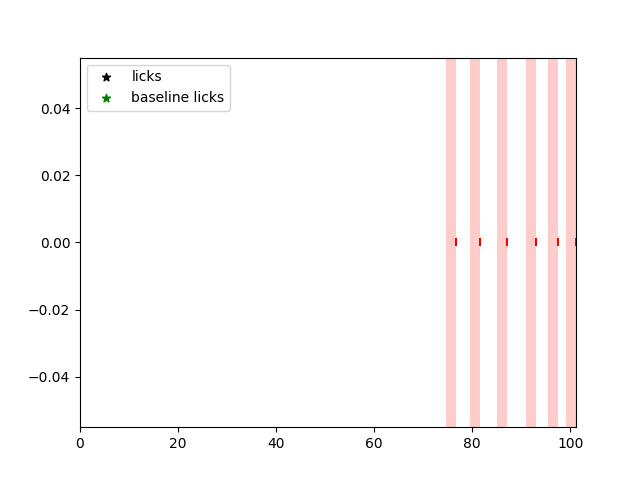


Mouse 2
------------------
Able to read movie?: True
The mouse have no pupil file
**SKIP** 


Mouse 3
------------------
Able to read movie?: True
The mouse have no pupil file


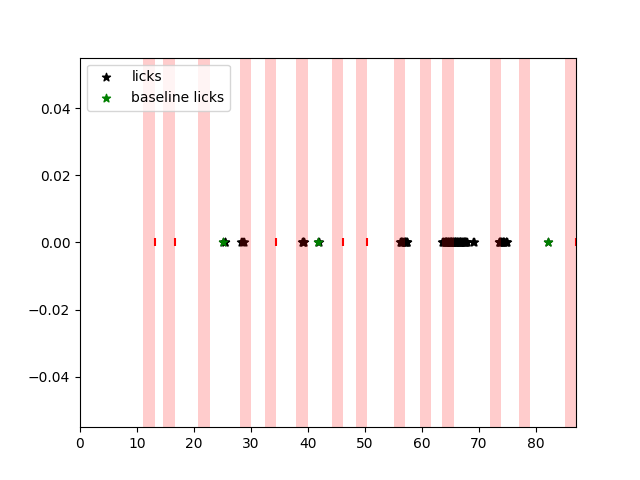


Mouse 4
------------------
Able to read movie?: True
The mouse have no pupil file


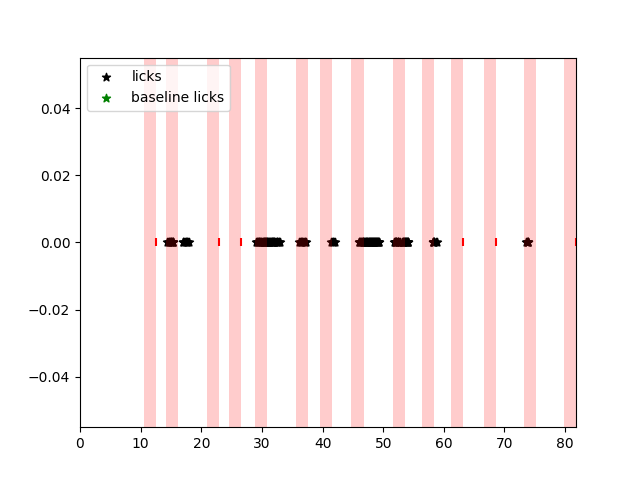


Mouse 5
------------------
Able to read movie?: True
The mouse have no pupil file


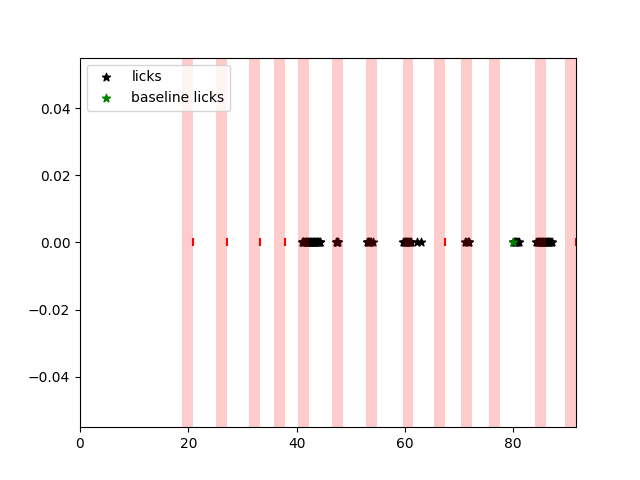


Mouse 6
------------------
Able to read movie?: True
The mouse have no pupil file


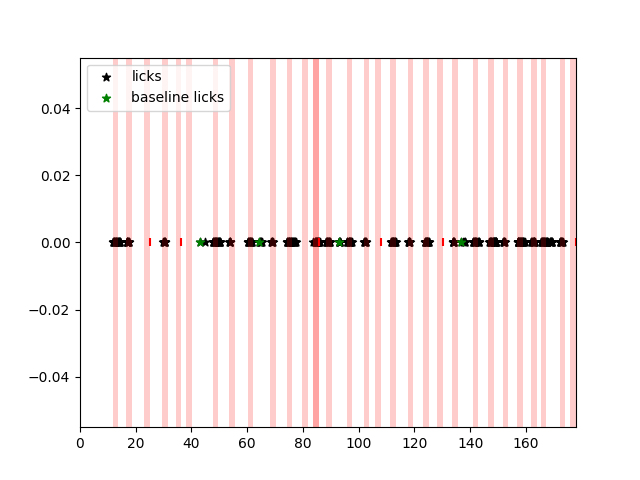


Mouse 7
------------------
Able to read movie?: True
The mouse have no pupil file


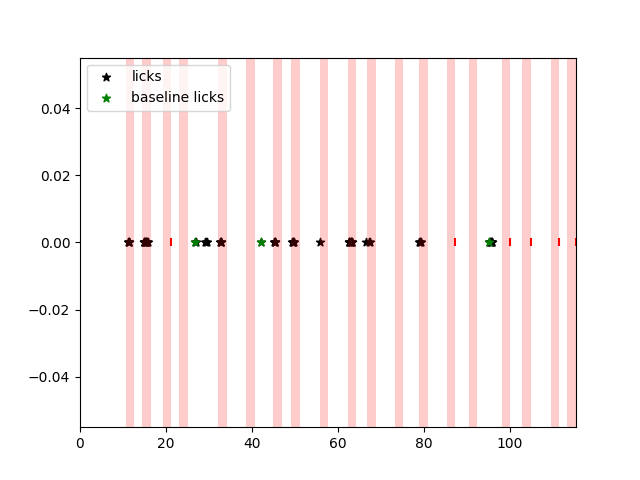


Mouse 8
------------------
Able to read movie?: True
The mouse have no pupil file


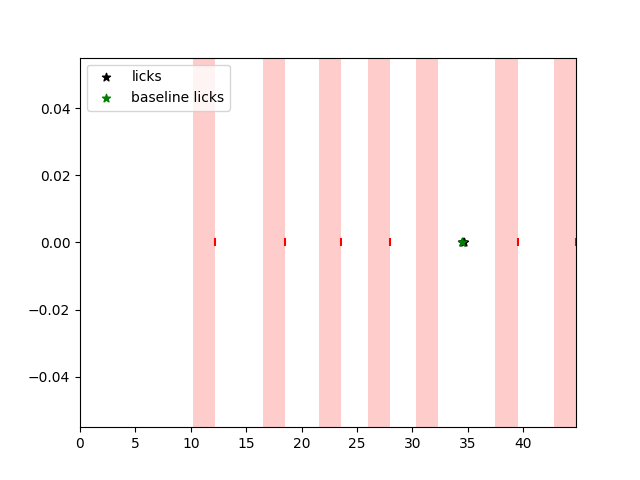

In [97]:
x, y = get_baseline(dir=dir, before_q=1, after_q = 2)

Train accuracy: 0.7425925925925924 || STD: 0.038445443503753146
Test accuracy: 0.5057142857142857 || STD: 0.12275743462251903
Lick Events: ~53% 
No-lick Events: ~47%


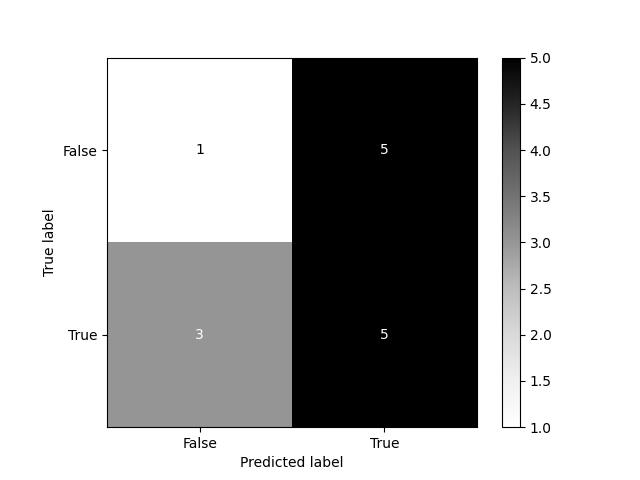

In [98]:


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm


K = 100
acc = np.zeros([K, 2])

for k in range(K):

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    #
    pca = PCA(n_components=10)
    X_train = pca.fit_transform(X_train, y_train)
    X_test = pca.transform(X_test)

    # Training and Making Predictions
    # classifier = GaussianNB()
    classifier = svm.SVC(kernel='rbf')
    # classifier = RandomForestClassifier(max_depth=2, random_state=0)

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    acc[k, 0] = accuracy_score(y_test, y_pred)
    train_pred = classifier.predict(X_train)
    acc[k, 1] = accuracy_score(y_train, train_pred)

# Evaluating the Performance
print('Train accuracy: ' + str(np.mean(acc[:, 1])) + ' || STD: ' + str(np.std(acc[:, 1])))
print('Test accuracy: ' + str(np.mean(acc[:, 0])) + ' || STD: ' + str(np.std(acc[:, 0])))

lick_bias = y.sum()/y.shape[0] * 100

print("Lick Events: ~" + str(round(lick_bias)) + "% \nNo-lick Events: ~" +str(round(100- lick_bias)) + "%")


cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greys')